# Spatial-temporal analysis
To probe spatial-temporal dynamics during early development, we used `SLAT` to align two spatial atlases of mouse embryonic development at E11.5 and E12.5.

In [1]:
import os
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
import torch
from anndata import AnnData
from joblib import Parallel, delayed
from harmony import harmonize
import plotly.graph_objects as go

import scSLAT
from scSLAT.model import run_SLAT_multi,load_anndatas, Cal_Spatial_Net, run_SLAT, scanpy_workflow, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey, match_3D_celltype, Sankey
from scSLAT.metrics import region_statistics

In [2]:
sc.set_figure_params(dpi=150, dpi_save=150)

In [3]:
adata1 = sc.read_h5ad('./adata1.h5ad')
adata2 = sc.read_h5ad('./adata2.h5ad')
print(f"adata1: {adata1.shape[0]} cells, adata2: {adata2.shape[0]} cells")

adata1: 10000 cells, adata2: 10001 cells


In [4]:
Cal_Spatial_Net(adata1, k_cutoff=50, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=50, model='KNN')
edges, features = load_anndatas([adata1, adata2], feature='DPCA', check_order=False)

Calculating spatial neighbor graph ...
The graph contains 537308 edges, 10000 cells.
53.7308 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 539939 edges, 10001 cells.
53.98850114988501 neighbors per cell on average.
Use DPCA feature to format graph


/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/rd2/user/xiacr/SLAT/scSLAT/model/preprocess.py:89: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.layers["counts"] = adata.X.copy()
/rd2/user/xiacr/SLAT/scSLAT/model/preprocess.py:89: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X

In [8]:
adata1.obsm['X_dpca'] = features[0].cpu().numpy()
adata2.obsm['X_dpca'] = features[1].cpu().numpy()

# run SLAT

In [10]:
embd0, embd1, time = run_SLAT(features, edges, LGCN_layer=5)

Choose GPU:5 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 1.87


In [11]:
best, index, distance = spatial_match([embd0, embd1], reorder=False, adatas=[adata1,adata2])

In [12]:
adata1_df = pd.DataFrame({'index':range(embd0.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index':range(embd1.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['annotation']})
matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]
region_statistics(best_match,start=0.5,number_of_interval=10)

0.500~0.550        13          0.130%
0.550~0.600        62          0.620%
0.600~0.650       231          2.310%
0.650~0.700       735          7.349%
0.700~0.750      1476         14.759%
0.750~0.800      1873         18.728%
0.800~0.850      1883         18.828%
0.850~0.900      1709         17.088%
0.900~0.950      1718         17.178%
0.950~1.000       300          3.000%


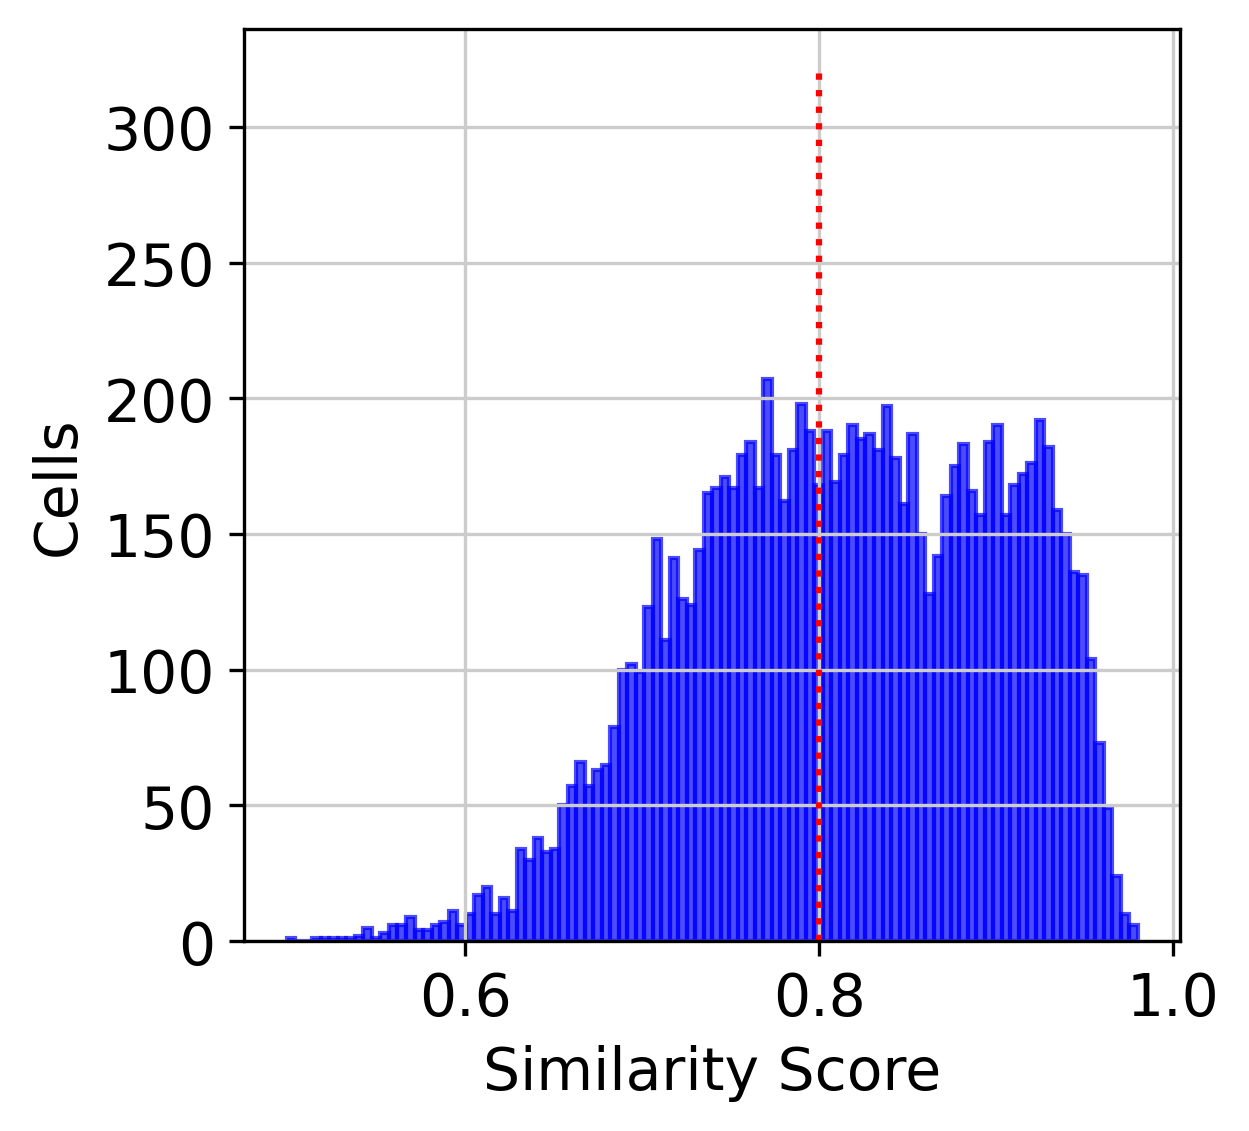

In [13]:
hist(best_match,cut=0.8,cut_height=320)

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Sclerotome', 'Inner ear', 'Head mesenchyme', 'Branchial arch', 'Dermomyotome', 'Surface ectoderm', 'Spinal cord', 'Mesentery', 'Sympathetic nerve', 'Kidney', 'Epidermis', 'Pancreas', 'Choroid plexus', 'Ovary', 'Cartilage primordium', 'Mucosal epithelium', 'Muscle', 'Mesothelium']]
Subsample 300 cell pairs from 10001


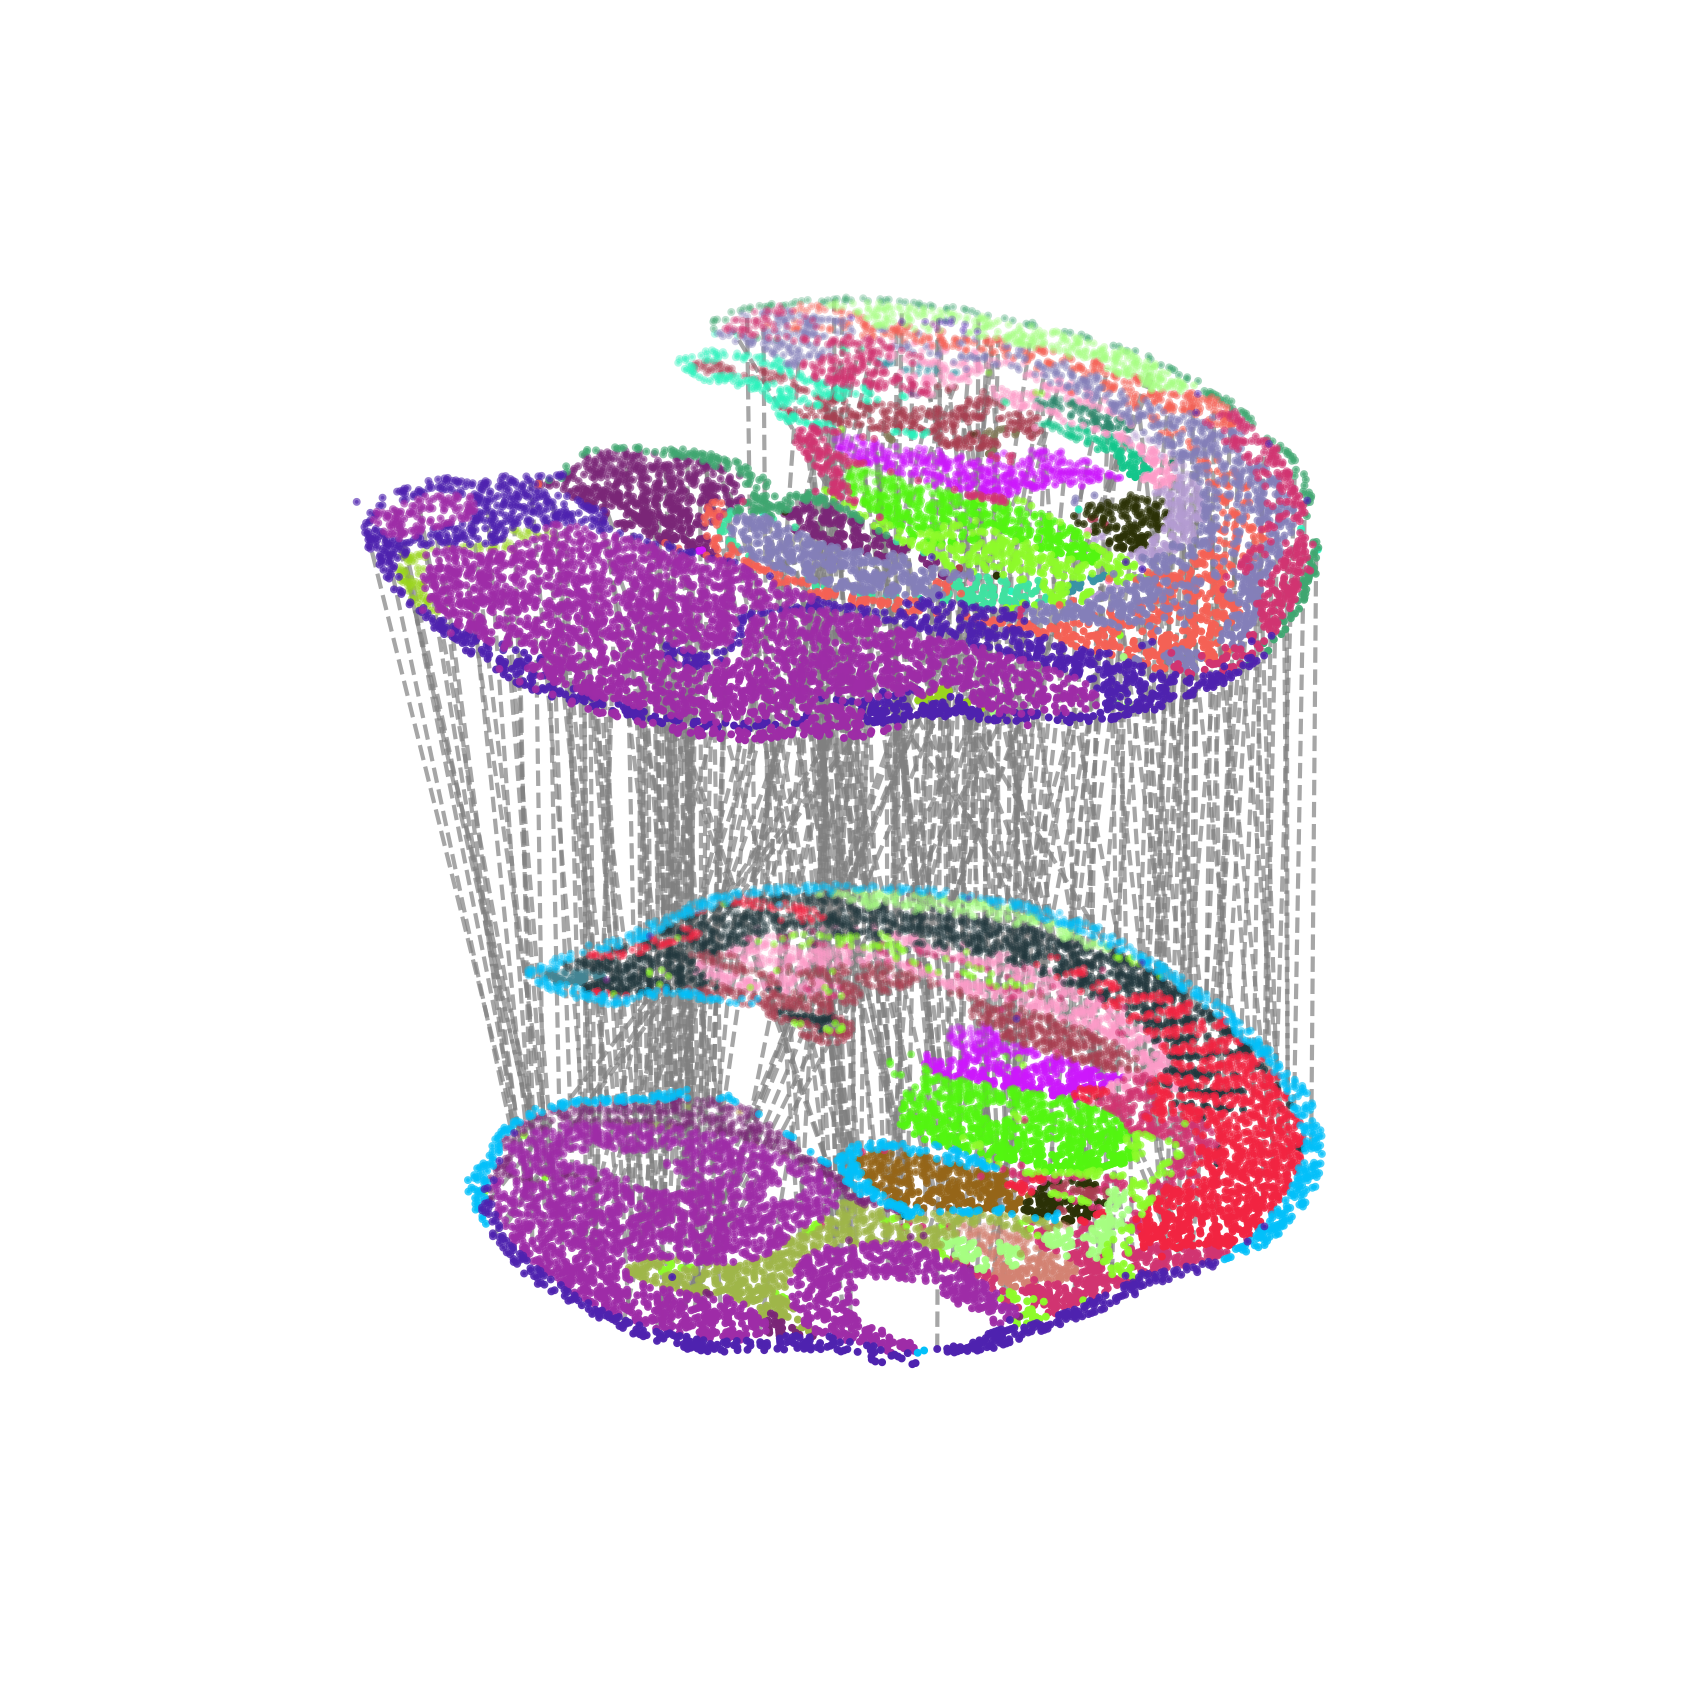

In [14]:
multi_align = match_3D_multi(adata1_df, adata2_df,matching,meta='celltype',
                             scale_coordinate=True,subsample_size=300,exchange_xy=False)

multi_align.draw_3D(size= [7, 8],line_width =1,point_size=[0.8,0.8], hide_axis=True,show_error=False)

In [15]:
adata2.obs['low_quality_index']= best_match 
adata2.obs['low_quality_index'] = adata2.obs['low_quality_index'].astype(float)

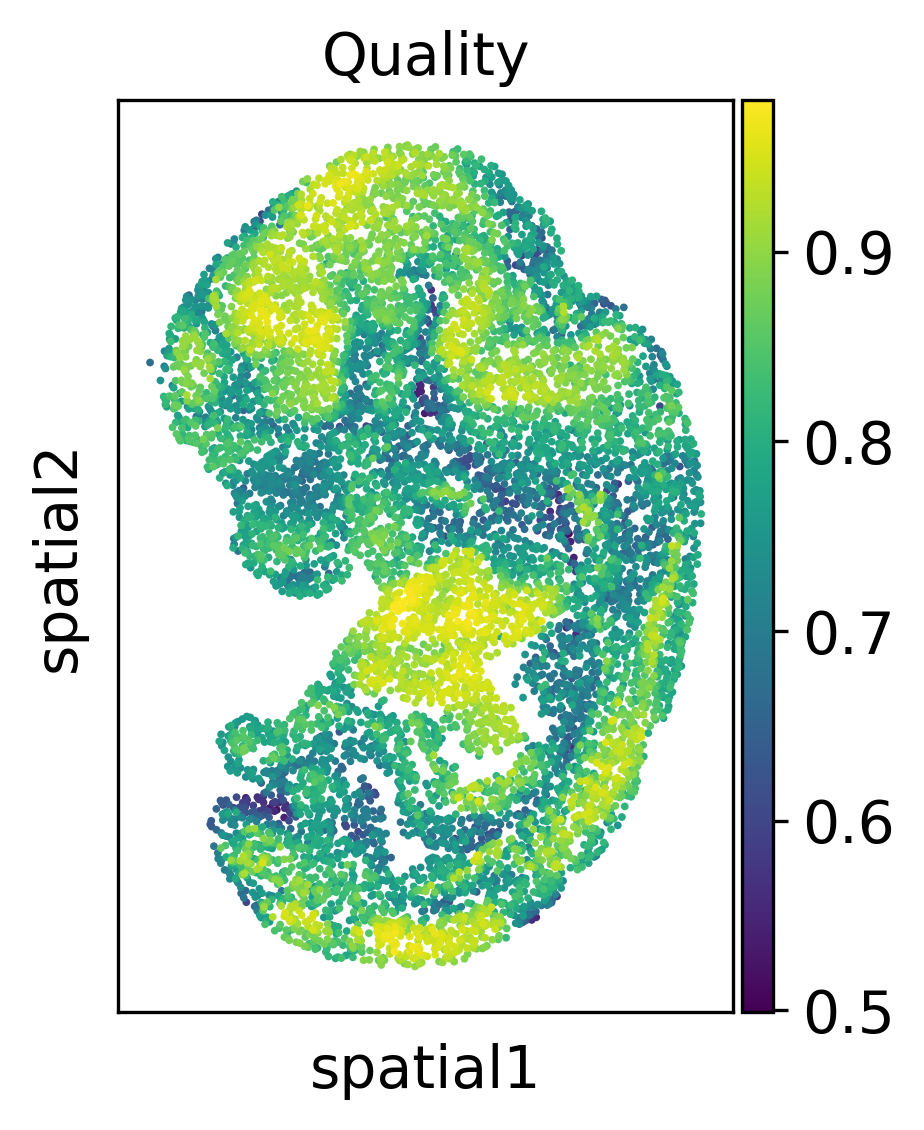

In [16]:
sc.pl.spatial(adata2, color='low_quality_index', spot_size=3, title='Quality')

In [17]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()

In [18]:
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [19]:
matching_table

target_celltype       Blood vessel  Brain  Branchial arch  Connective tissue  \
celltype                                                                       
Blood vessel                    28      0               0                 67   
Brain                            1   2469               0                  3   
Cartilage primordium            11      0               0                174   
Choroid plexus                   0     83               0                  0   
Connective tissue                2      0               0                 22   
Dorsal root ganglion             0      0               0                  2   
Epidermis                        0      0               0                  0   
GI tract                         1      0               0                 13   
Heart                            1      0               0                  0   
Jaw and tooth                    2      0             108                  4   
Kidney                           0      0               0                  0   
Liver                            9      0               0                  0   
Lung primordium                  0      0               0                 17   
Meninges                        40    158               0                122   
Mesentery                        1      0               1                  3   
Mesothelium                      0      0               0                 53   
Mucosal epithelium               0      0              14                  2   
Muscle                           0      0              96                 55   
Ovary                            0      0               0                  0   
Pancreas                         0      0               0                  0   
Sympathetic nerve                1      0               0                  3   
Urogenital ridge                 1      0               0                  6   

target_celltype       Dermomyotome  Dorsal root ganglion  GI tract  \
celltype                                                             
Blood vessel                     5                     0         0   
Brain                            0                     2         0   
Cartilage primordium           123                     4         0   
Choroid plexus                   0                     0         0   
Connective tissue              209                     0        89   
Dorsal root ganglion             0                   255         0   
Epidermis                        5                    15         0   
GI tract                         1                     0       208   
Heart                            0                     0         0   
Jaw and tooth                    9                     0         1   
Kidney                           0                     0         1   
Liver                            0                     0         0   
Lung primordium                  1                     0        36   
Meninges                         1                     8         0   
Mesentery                        2                     0       168   
Mesothelium                     29                     0         0   
Mucosal epithelium               5                     0         3   
Muscle                         835                     0        26   
Ovary                            0                     0         2   
Pancreas                         0                     0        14   
Sympathetic nerve                0                    15         0   
Urogenital ridge                 1                     0         1   

target_celltype       Head mesenchyme  Heart  Inner ear  Jaw and tooth  Liver  \
celltype                                                                        
Blood vessel                        3    148          0              0      2   
Brain                              18      0          5              8      0   
Cartilage primordium               59      0          0             41    

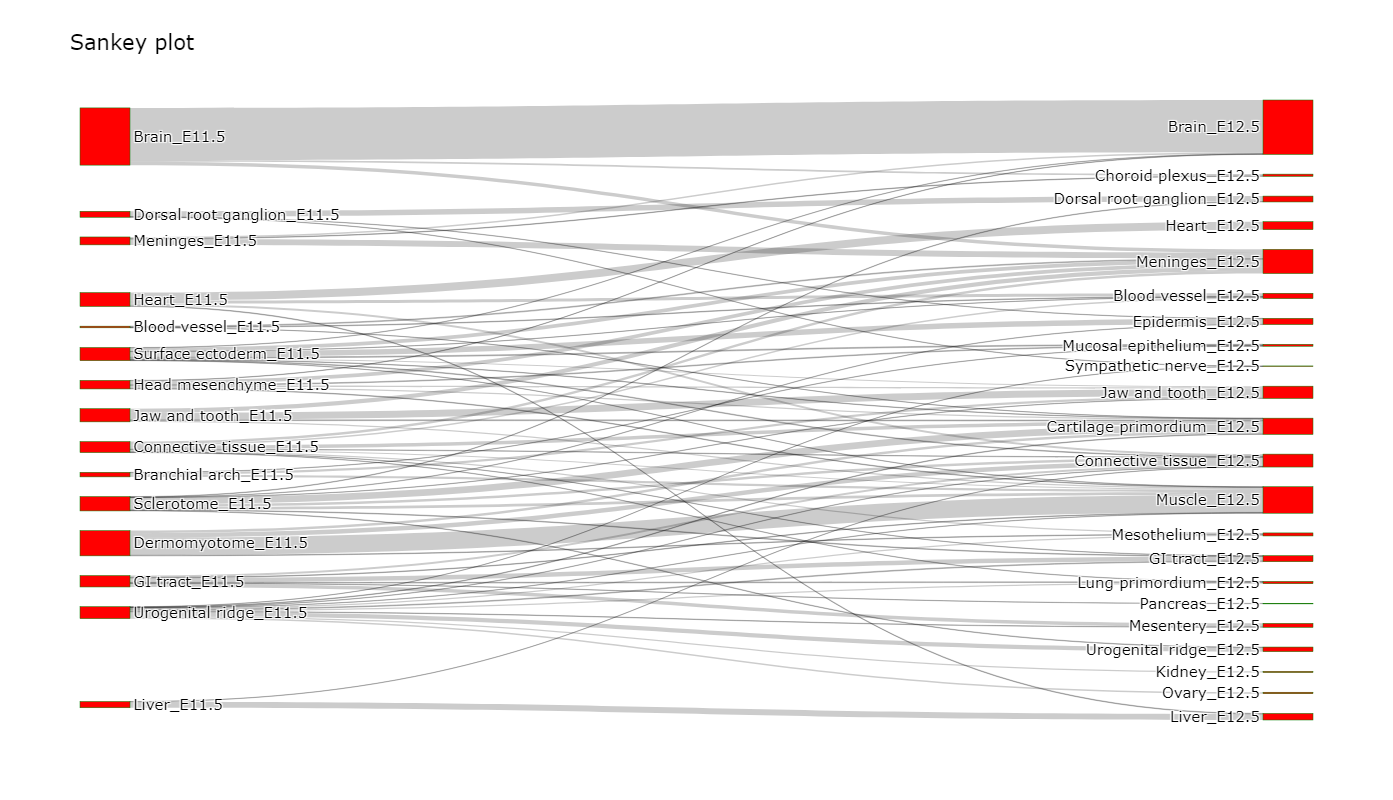

In [91]:
Sankey(matching_table, layout=[650,800], font_size=15)

# Kidney in development

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Sclerotome', 'Inner ear', 'Head mesenchyme', 'Branchial arch', 'Dermomyotome', 'Surface ectoderm', 'Spinal cord', 'Mesentery', 'Sympathetic nerve', 'Kidney', 'Epidermis', 'Pancreas', 'Choroid plexus', 'Ovary', 'Cartilage primordium', 'Mucosal epithelium', 'Muscle', 'Mesothelium']]
Subsample 10000 cell pairs from 10001


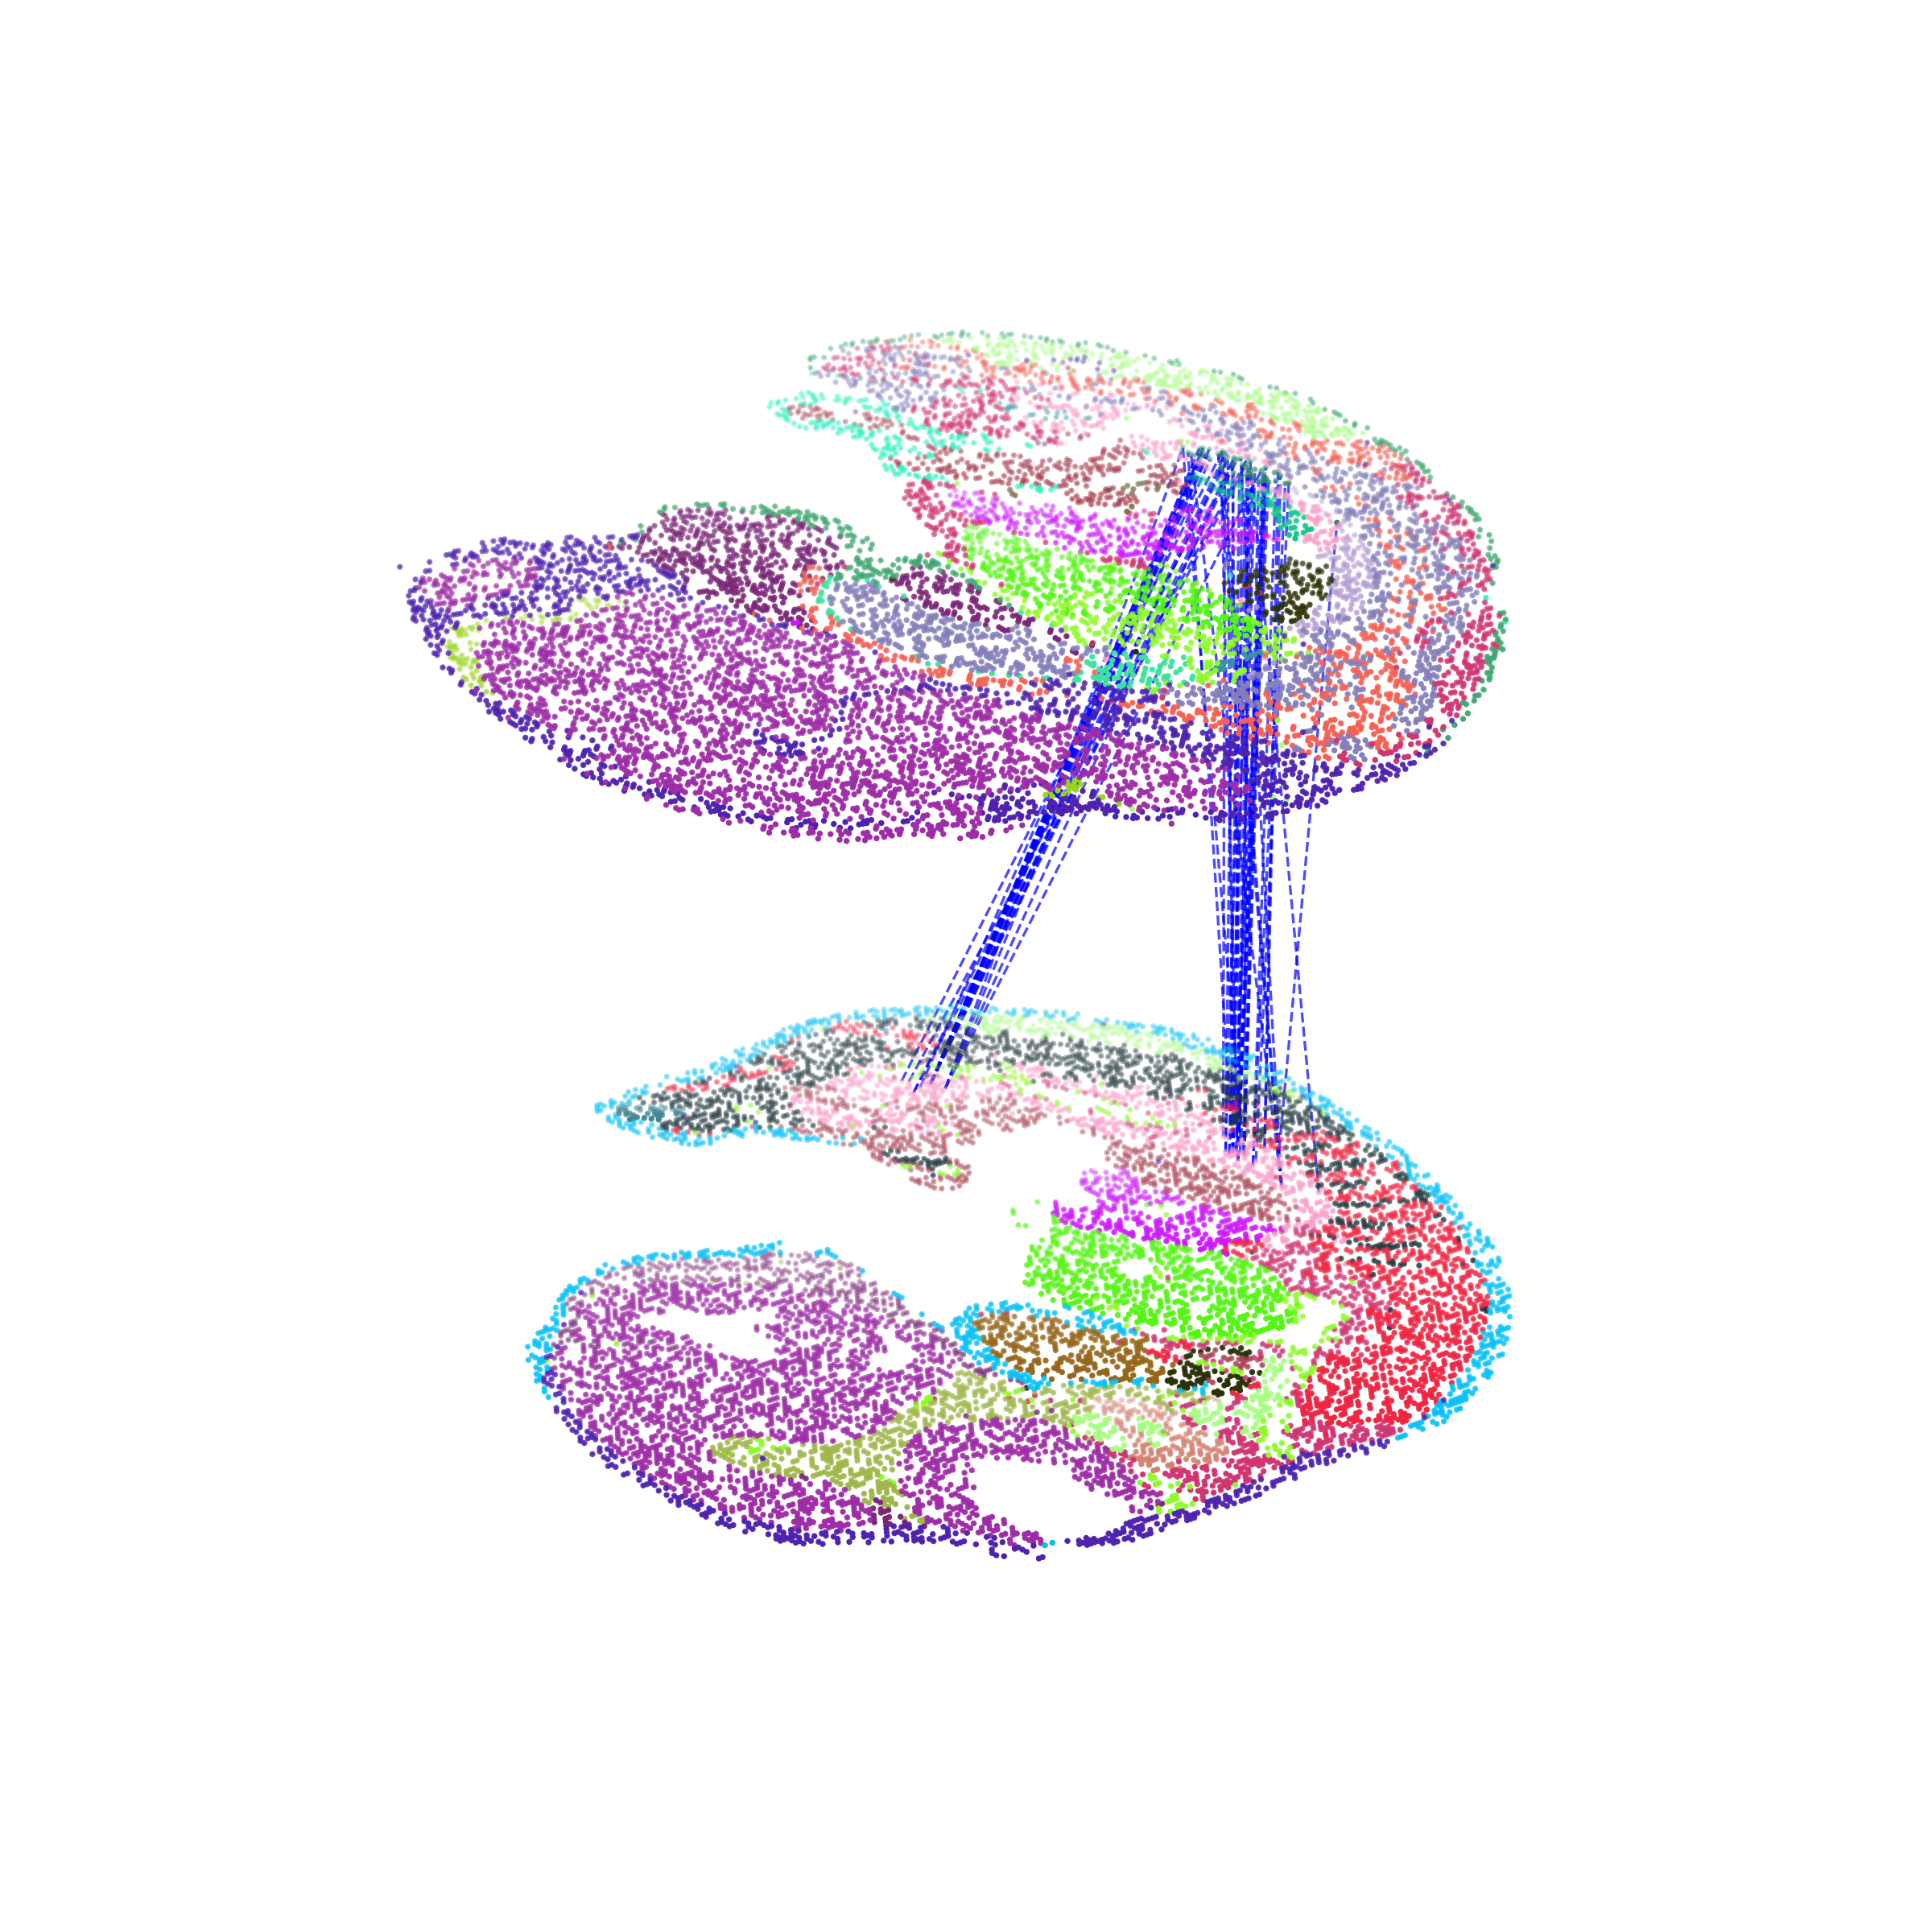

In [30]:
test = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', highlight_celltype = [['Urogenital ridge'],['Kidney']],subsample_size=10000, highlight_line = ['blue'],scale_coordinate = True )
test.draw_3D(size= [10, 12],line_width =0.8,point_size=[0.6,0.6], hide_axis=True)

# Ovary in development

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Sclerotome', 'Inner ear', 'Head mesenchyme', 'Branchial arch', 'Dermomyotome', 'Surface ectoderm', 'Spinal cord', 'Mesentery', 'Sympathetic nerve', 'Kidney', 'Epidermis', 'Pancreas', 'Choroid plexus', 'Ovary', 'Cartilage primordium', 'Mucosal epithelium', 'Muscle', 'Mesothelium']]
Subsample 10000 cell pairs from 10001


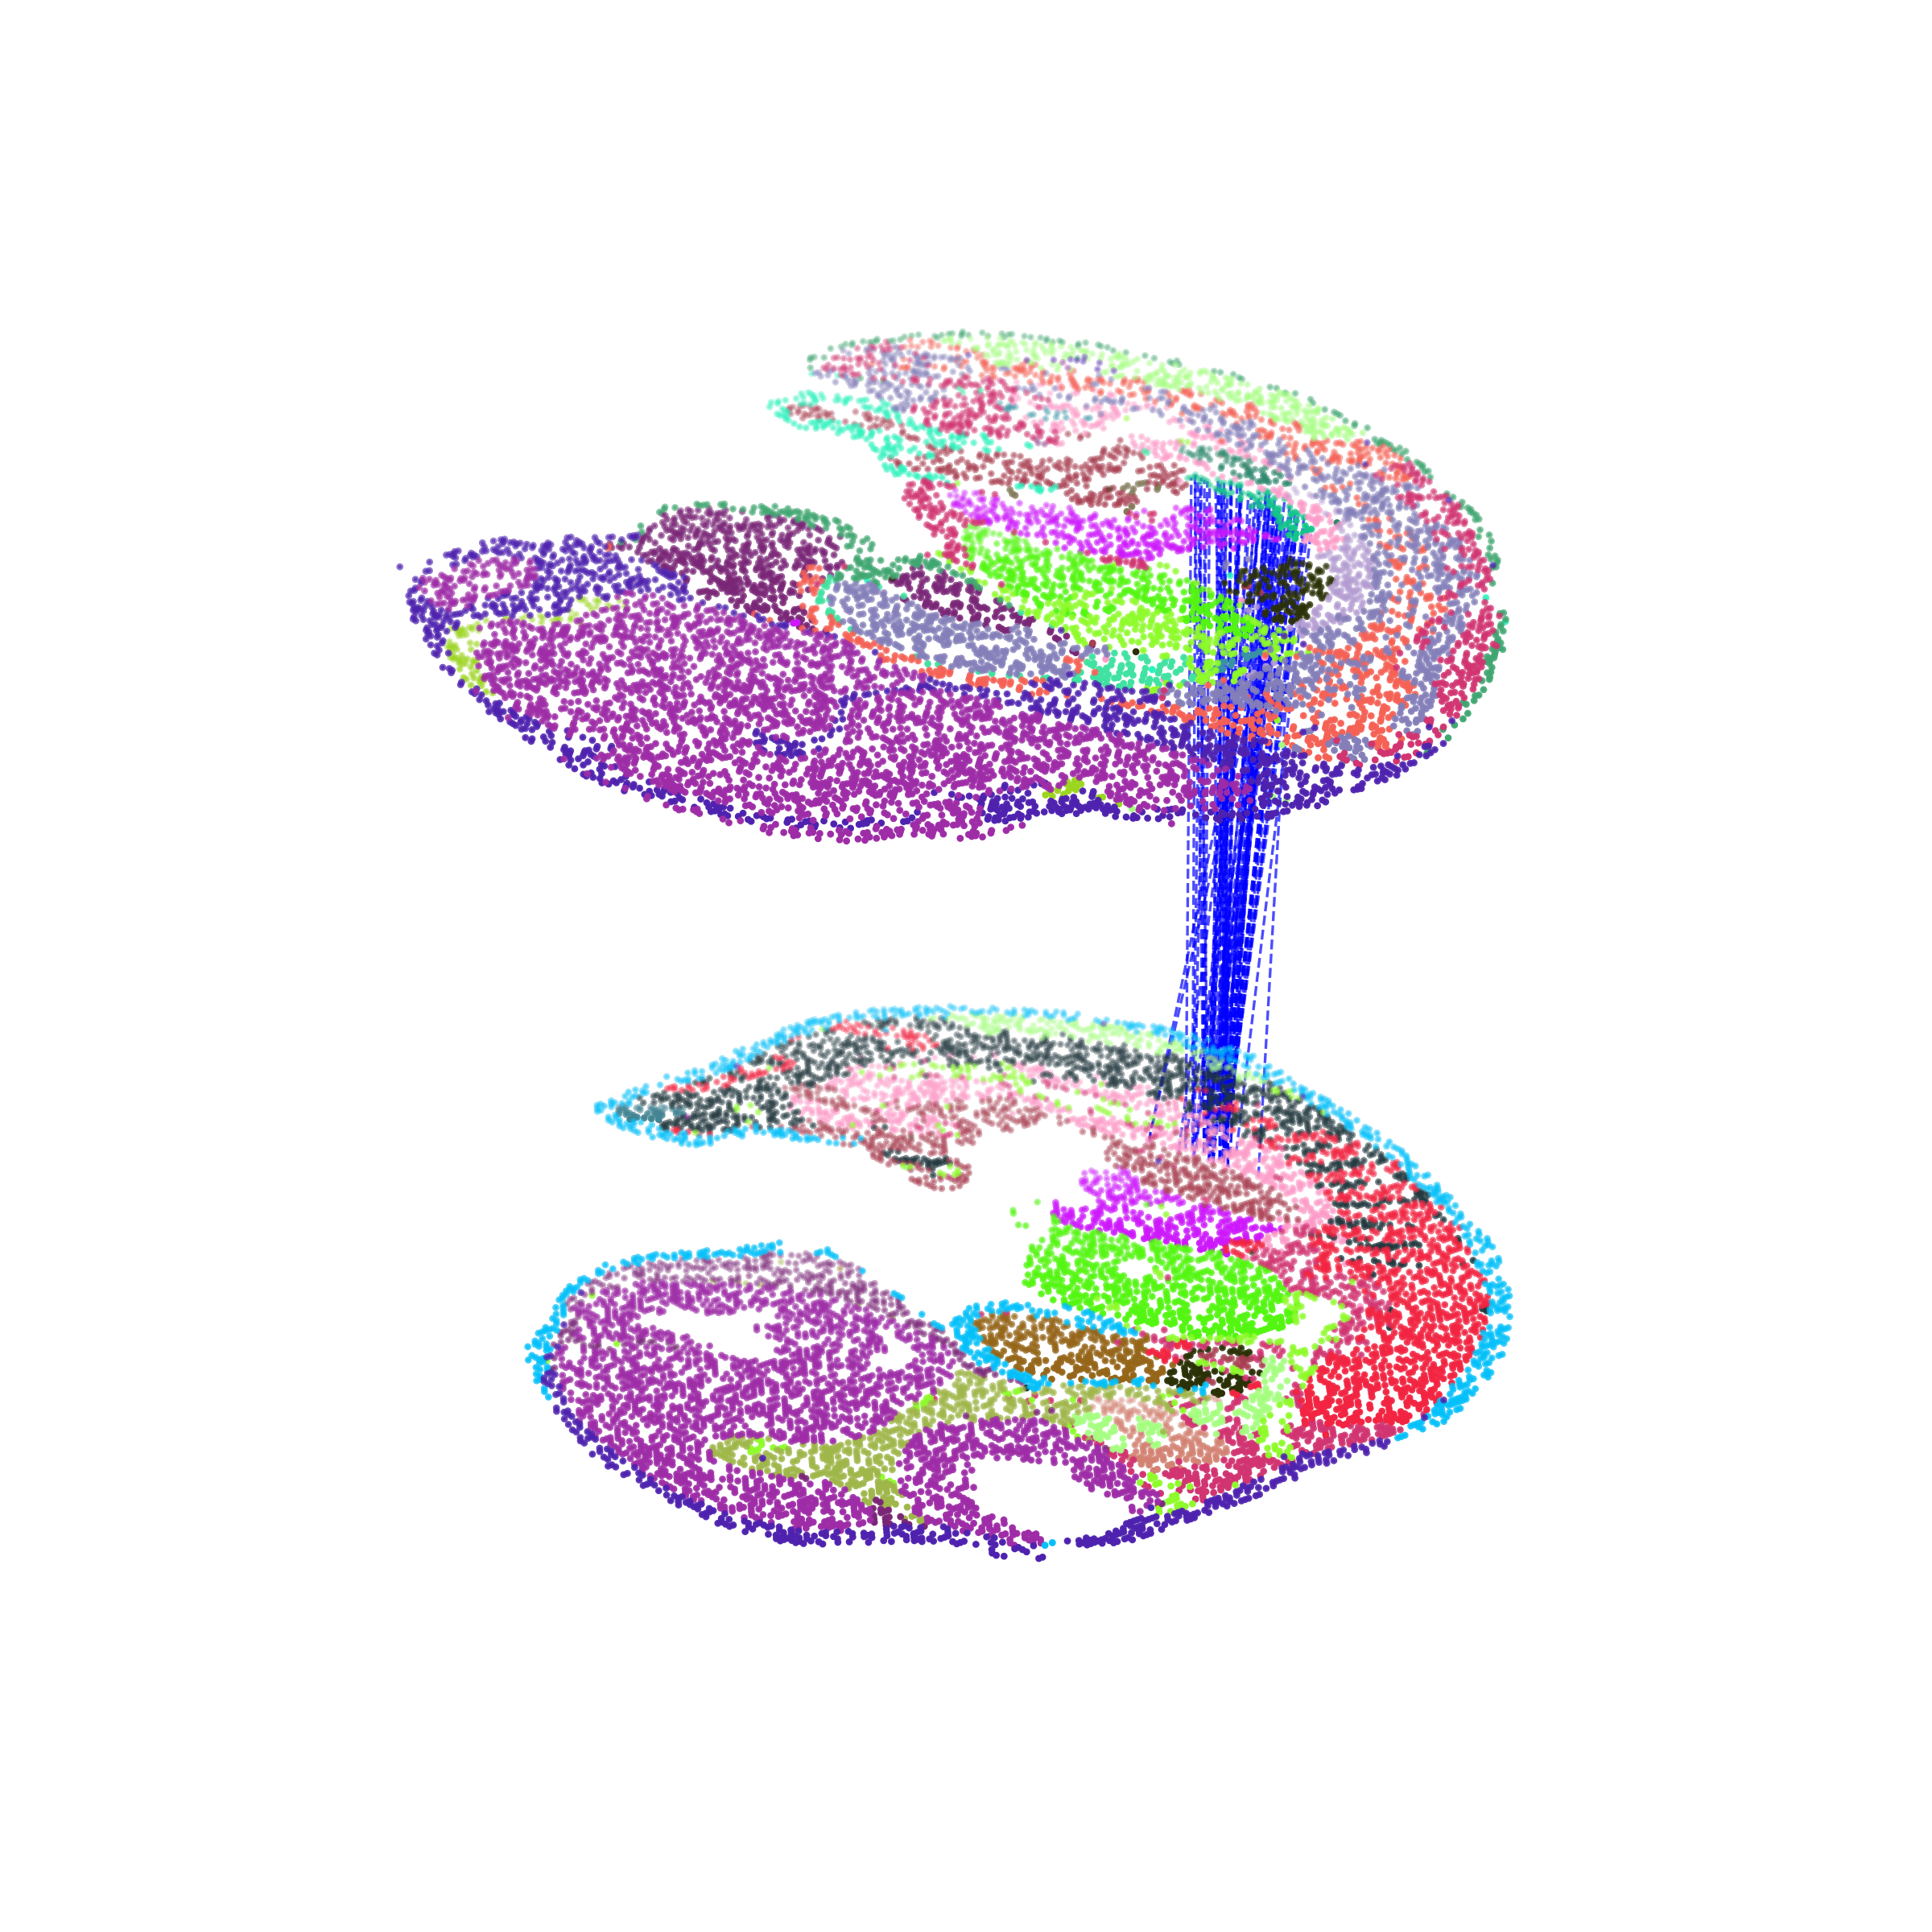

In [31]:
test = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', highlight_celltype = [['Urogenital ridge'],['Ovary']],subsample_size=10000, highlight_line = ['blue'],scale_coordinate = True)
test.draw_3D(size= [10, 12],line_width =0.8,point_size=[1.2,1.2], hide_axis=True)

# Save data

In [ ]:
adata1.write_h5ad('./adata1_processed.h5ad')
adata2.write_h5ad('./adata2_processed.h5ad')